In [6]:
%pip install matplotlib seaborn plotly streamlit
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
%pip install jaxtyping transformer_lens
%pip install ..

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Processing /home/andrew/Documents/Code/MechIR
  Preparing metadata (setup.py) ... done
  Created wheel for mechir: filename=mechir-0.0.1-py3-none-any.whl size=72933 sha256=b461805fe75547b5691aae57d523edf81649a086b0cb902c43b1295c73a02751
  Stored in directory: /tmp/pip-ephem-wheel-cache-awl0p9fs/wheels/16/4d/fd/e2f041bb0629a1af518d10cab4601f84986b0213a8a30041cf
Successfully built mechir
  Attempting uninstall: mechir
    Found existing installation: mechir 0.0.1
    Uninstalling mechir-0.0.1:
      Successfully uninstalled mechir-0.0.1
Note: you may need to restart the kernel to use updated packages.


In [7]:
from mechir.plotting import plot_components
import os
import numpy as np

In [8]:
DIR = r'../data/patching/'

In [9]:
out = {}
for file in os.listdir(DIR):
    out[file] = np.load(DIR + file)

/home/andrew/miniconda3/lib/python3.12/site-packages/mechir/plotting/plotting_funcs.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


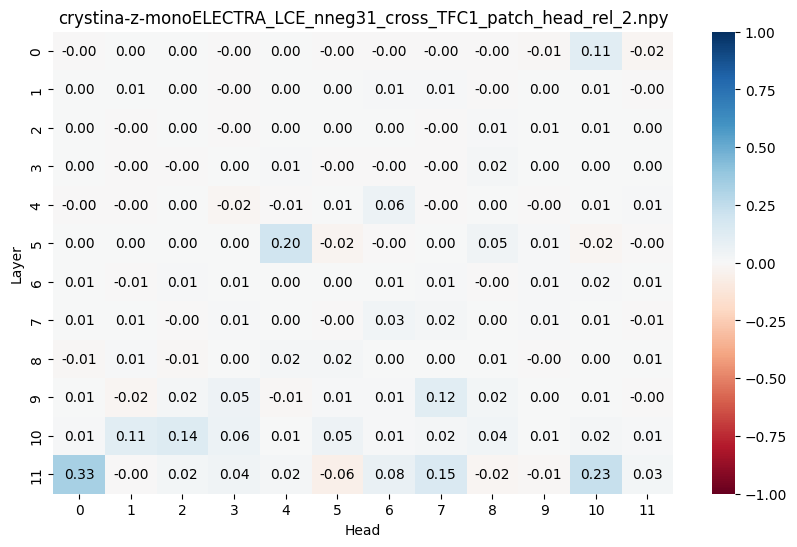

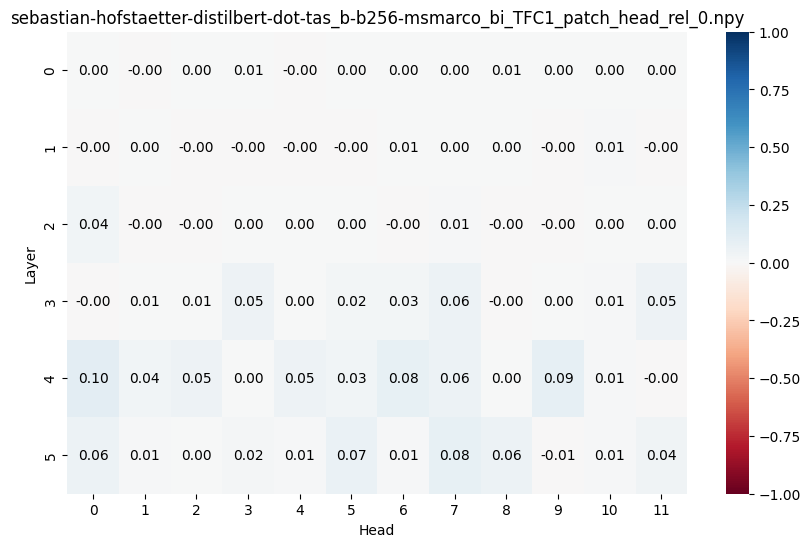

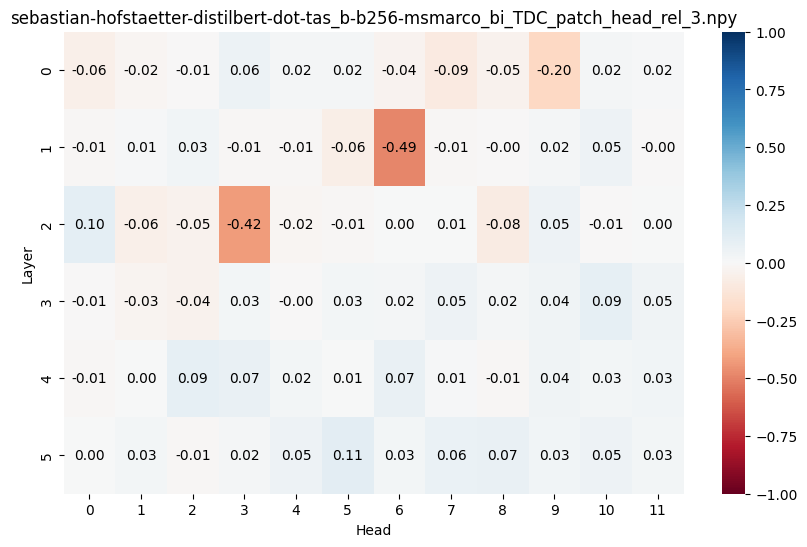

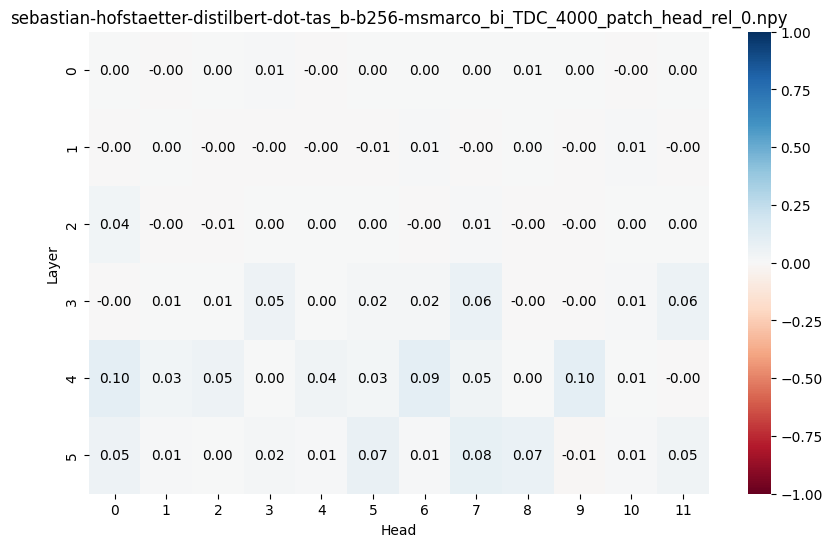

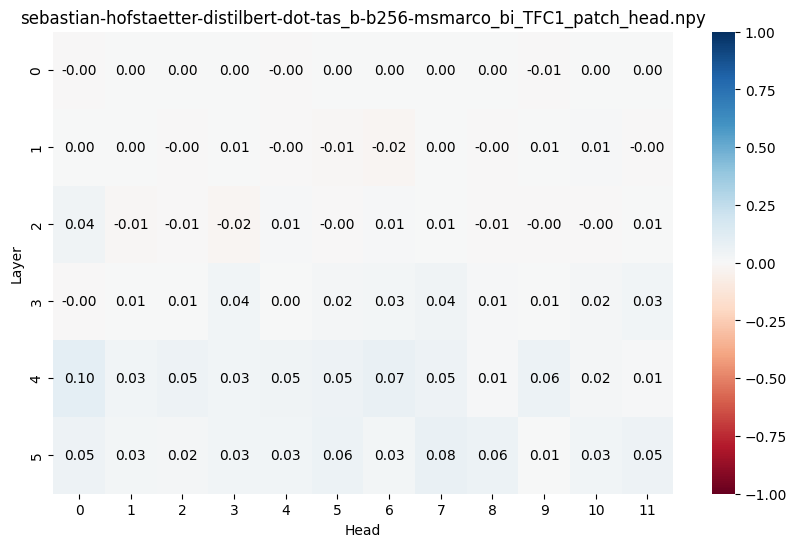

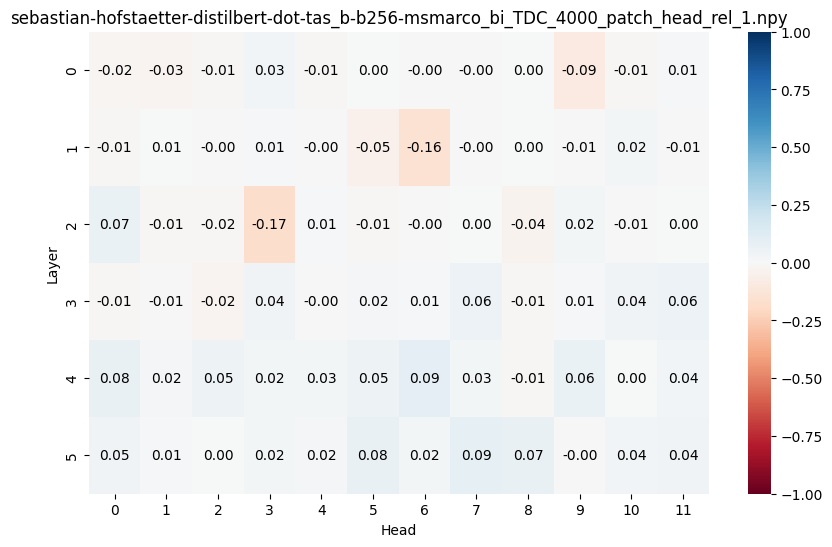

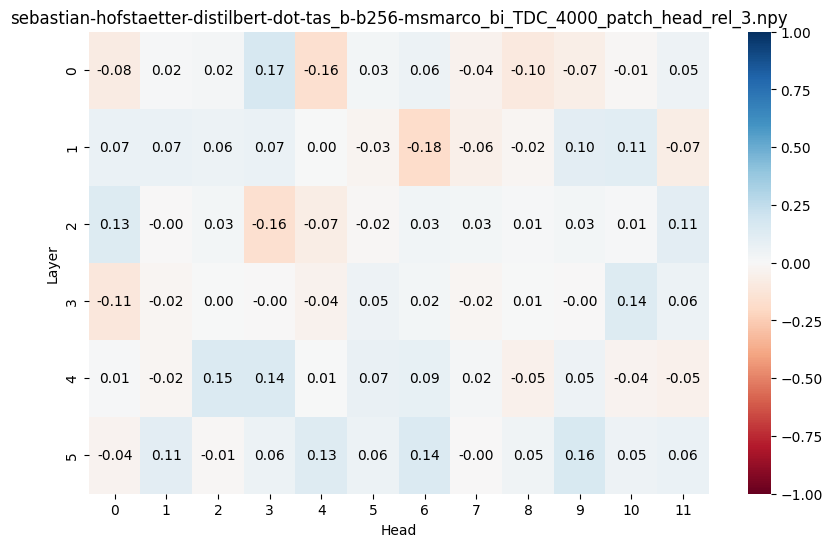

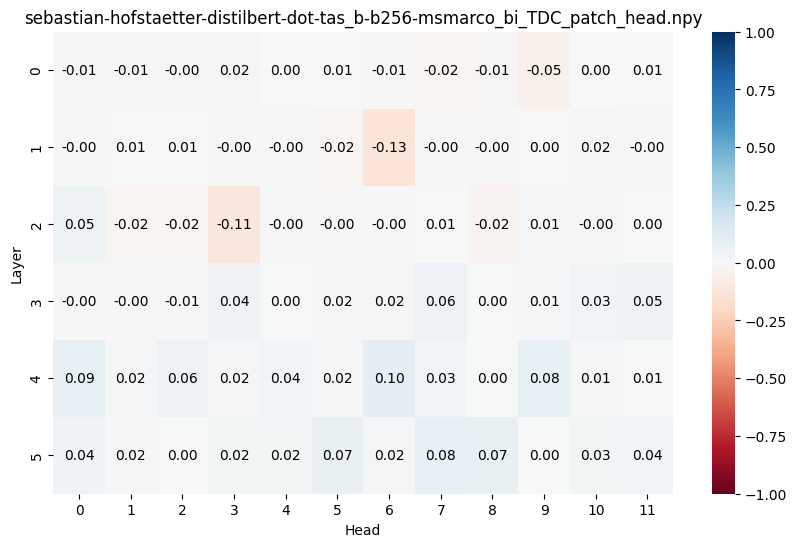

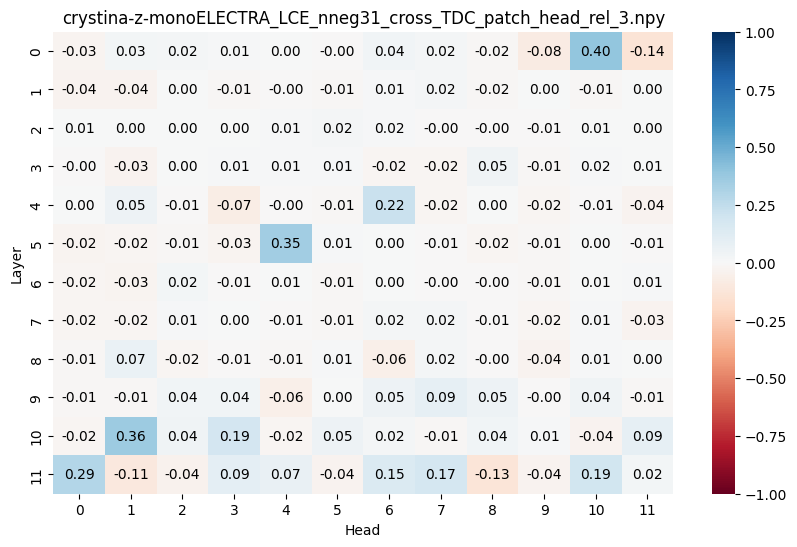

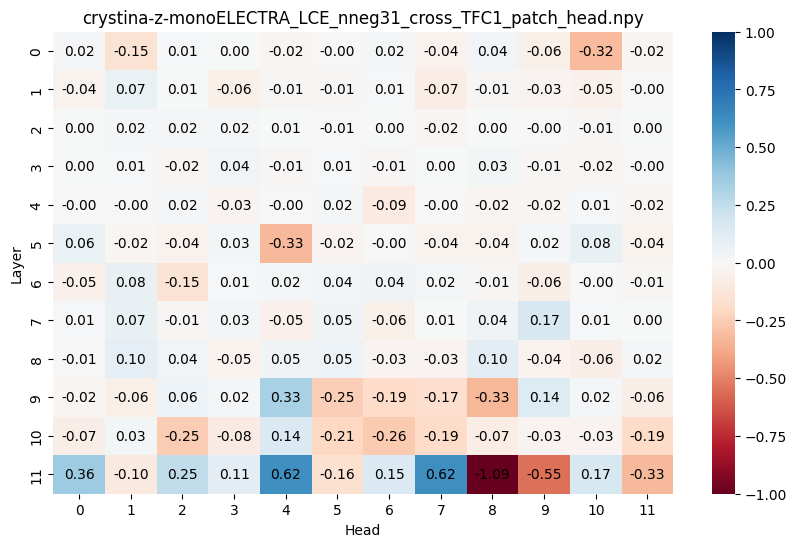

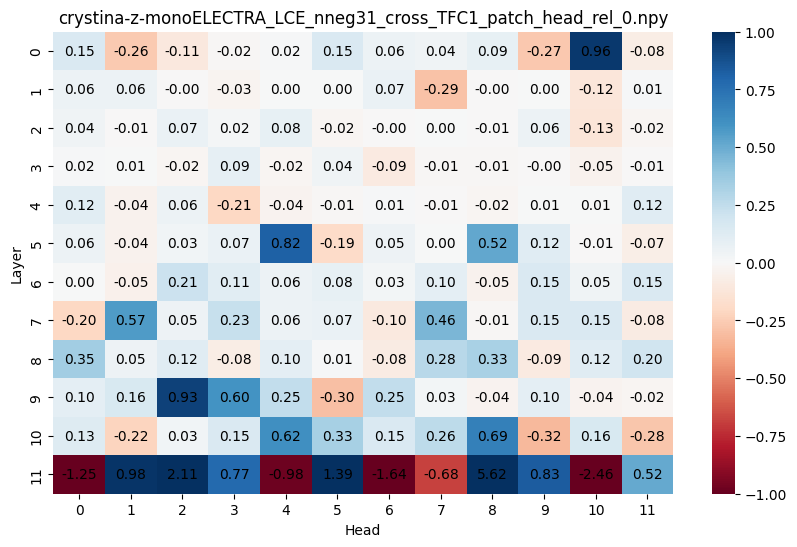

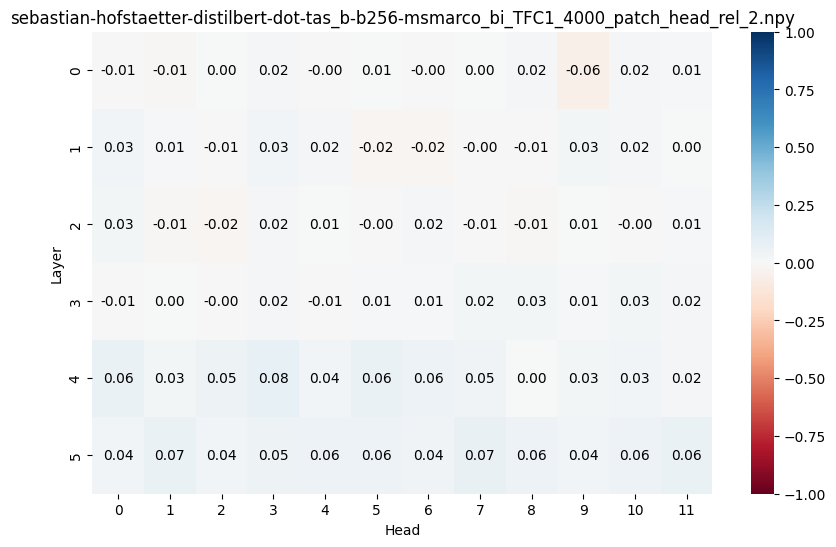

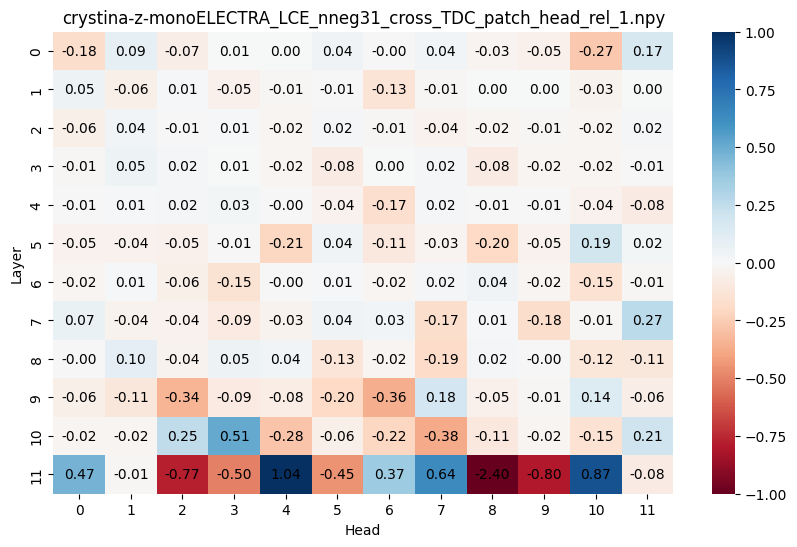

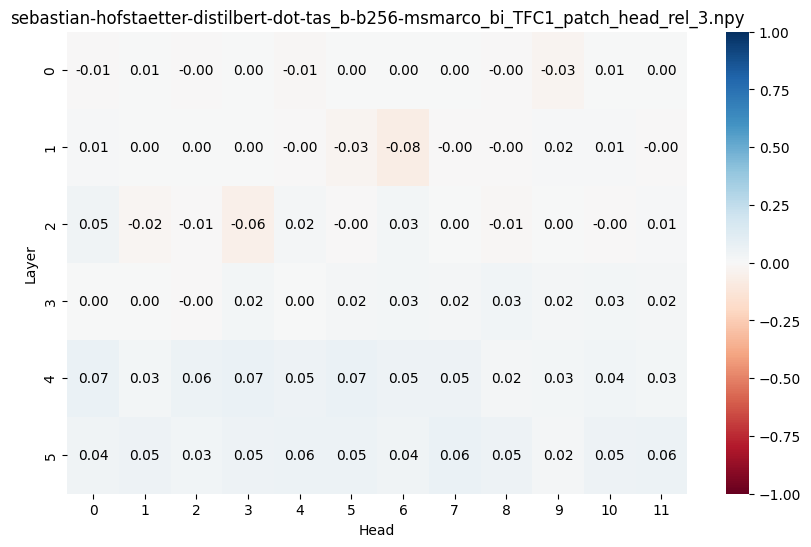

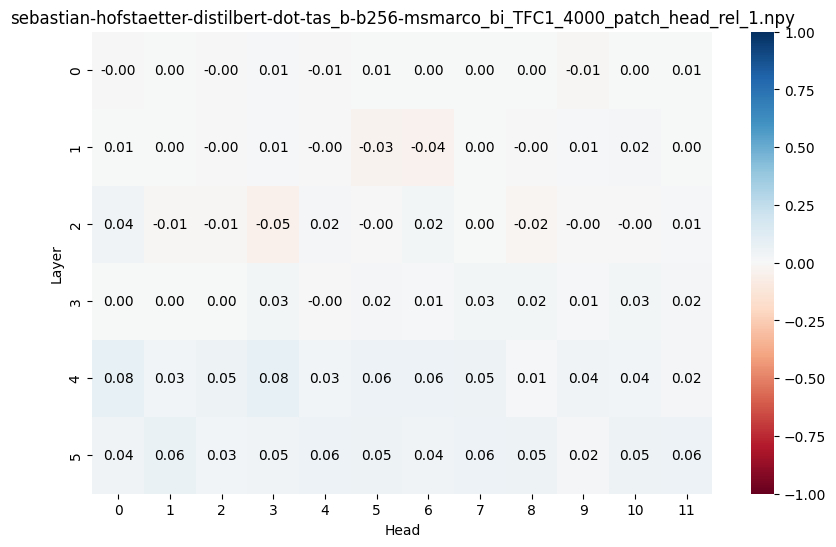

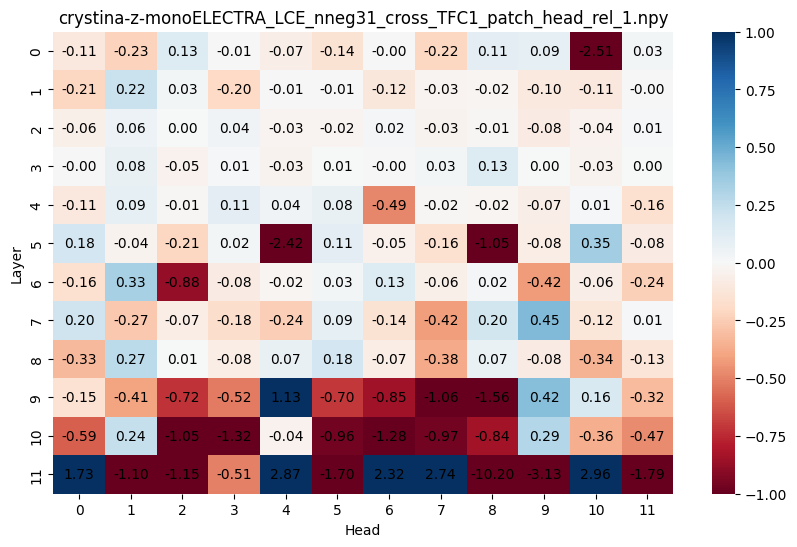

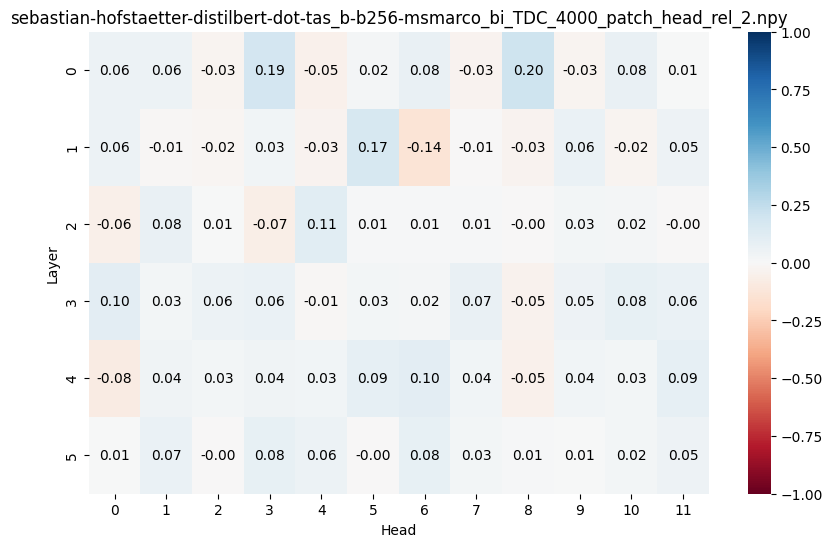

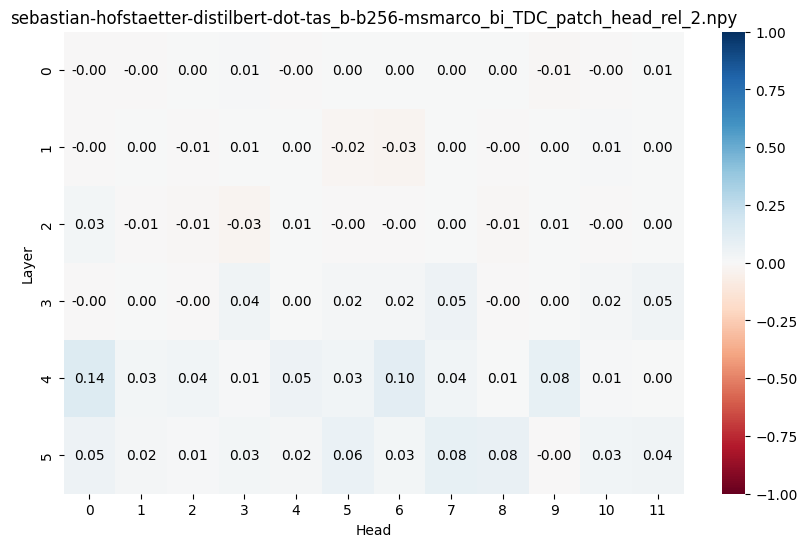

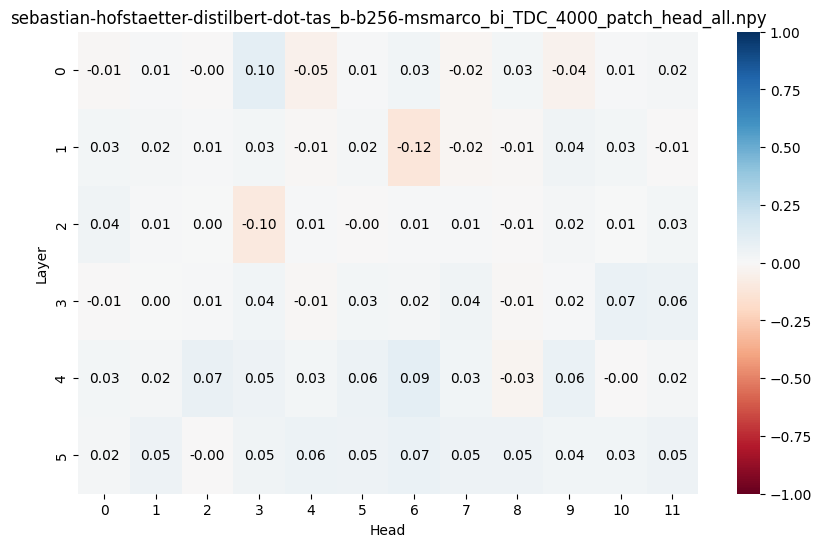

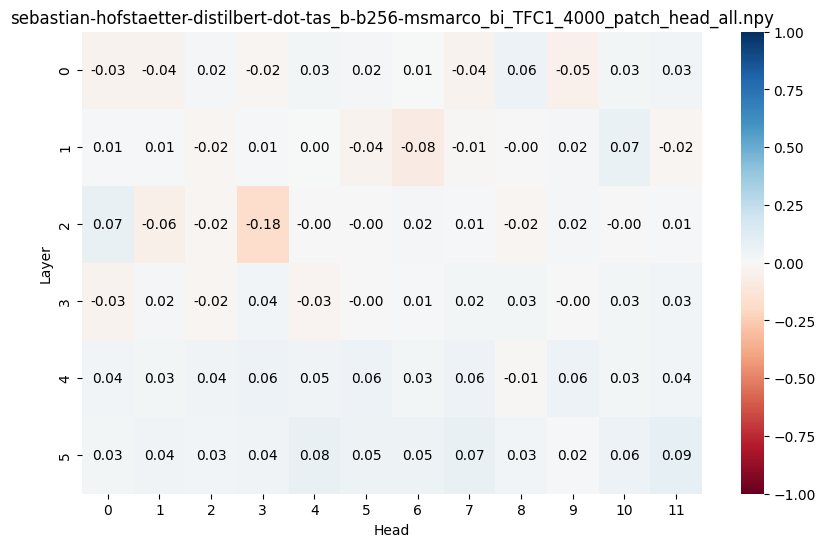

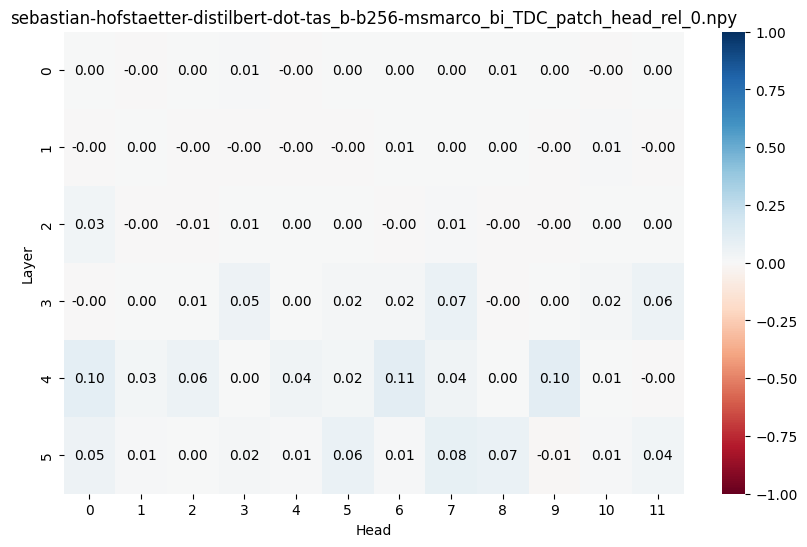

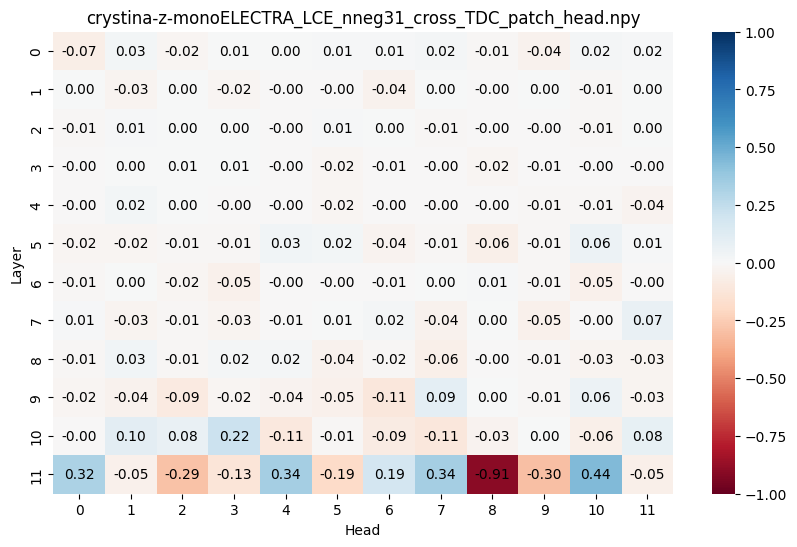

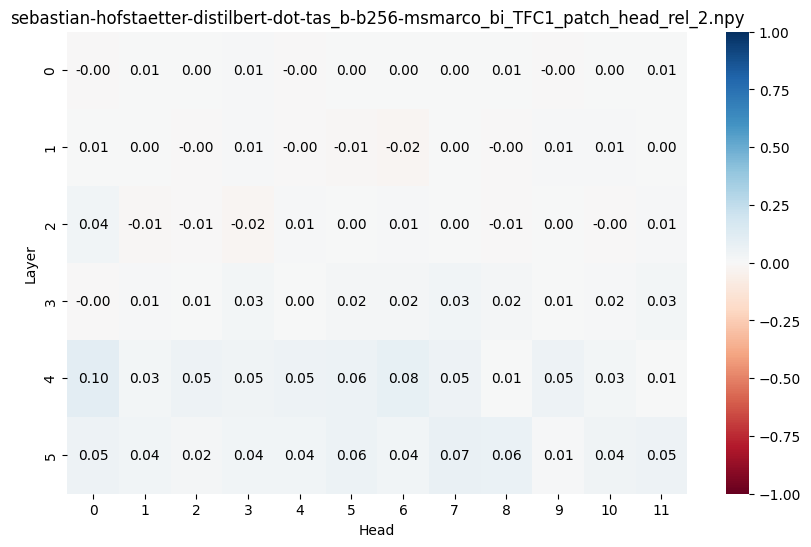

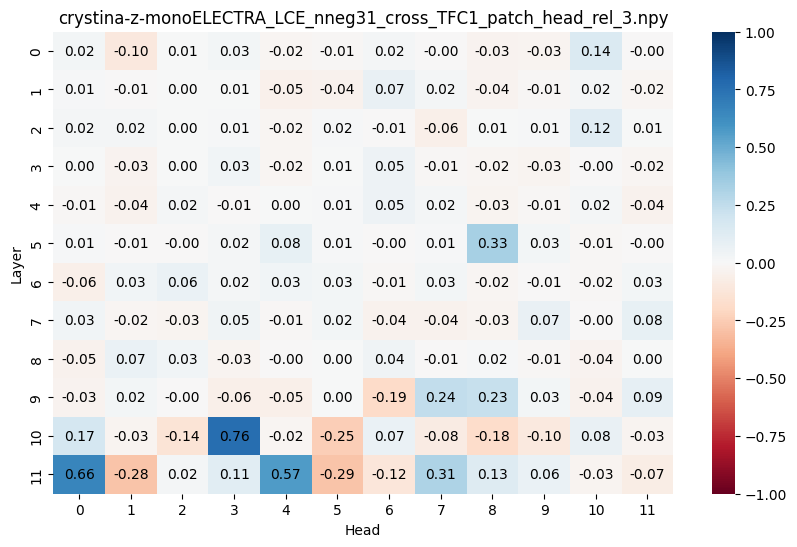

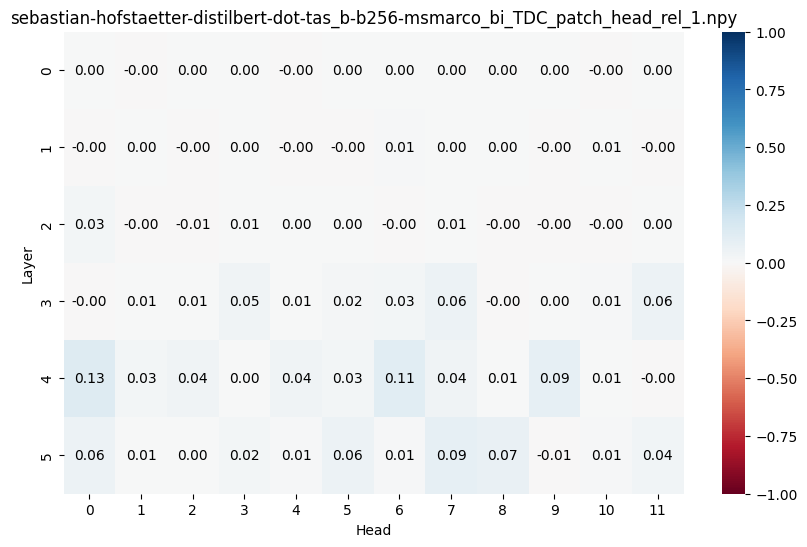

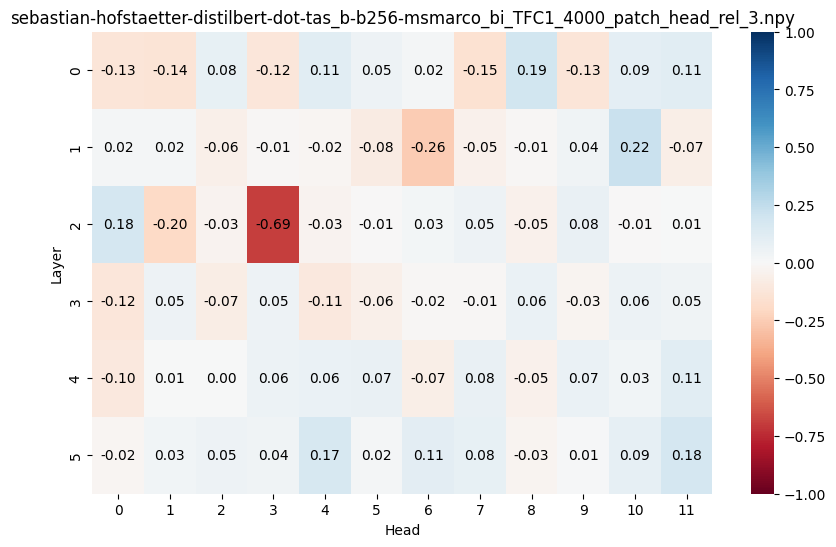

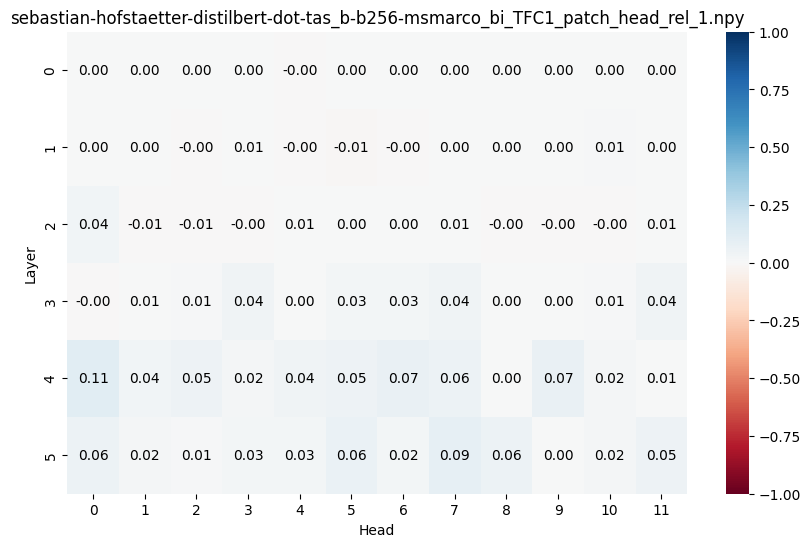

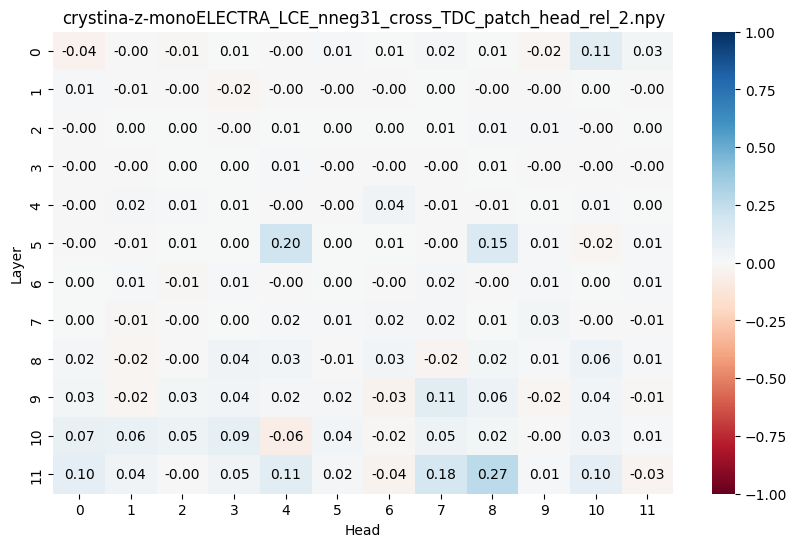

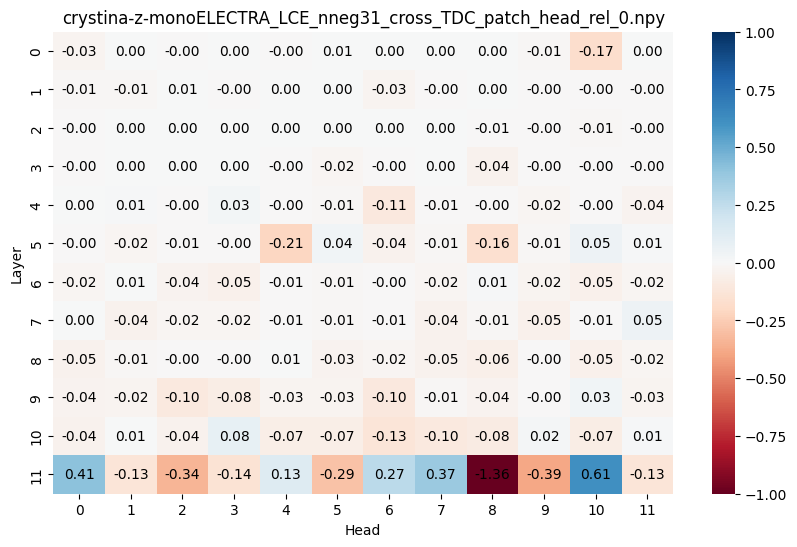

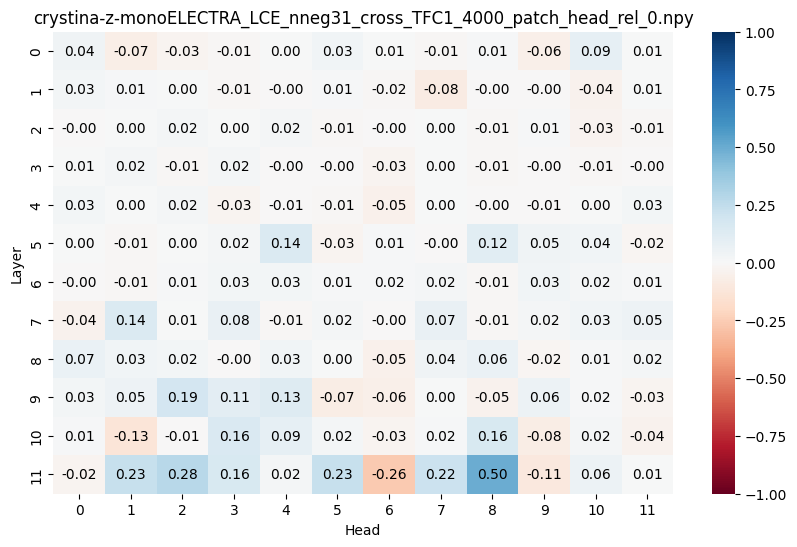

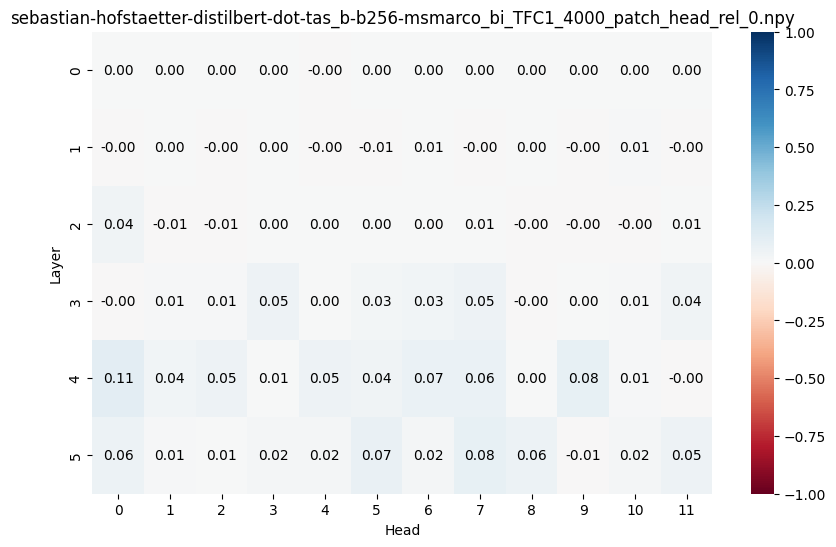

In [10]:
for file in out:
    plot_components(out[file], title=file, save_path=None, include_mlp=False)